In [11]:
import json
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sentence_transformers import SentenceTransformer, util
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# 函数

In [12]:
def calculate_commits_freq(commits):
    if isinstance(commits, list):
        return len(commits)
    else:
        return 0


def calculate_releases_freq(releases):
    if isinstance(releases, list):
        return len(releases)
    else:
        return 0


def calculate_readme_size(readme):
    if isinstance(readme, str):
        return len(readme)
    else:
        return 0


def calculate_lines_of_codes(languages):
    if isinstance(languages, dict):
        return sum(languages.values())
    return 0


def calculate_number_of_releases(releases):
    if isinstance(releases, list):
        return len(releases)
    return 0


def calculate_popularity_score_1(stars, forks, pull_requests):
    return stars + forks + pull_requests * pull_requests


def calculate_popularity_score_2(watchers, pull_requests):
    return watchers + pull_requests * pull_requests


def calculate_popularity_score_3(stars, forks):
    return stars + forks

def classify_topics(topics):
    if topics is None or topics is [] or len(topics) == 0:
        return "unknown"
    model = SentenceTransformer('all-MiniLM-L6-v2')
    candidate_labels = ["operating system", "networking", "cybersecurity", "software development", "web", "AI", "database", "documentation", "programming language"]
    topic_embeddings = model.encode(topics)
    label_embeddings = model.encode(candidate_labels)
    similarities = util.pytorch_cos_sim(topic_embeddings, label_embeddings)
    best_labels = [candidate_labels[idx] for idx in similarities.argmax(dim=1)]
    return max(set(best_labels), key=best_labels.count)


def detect_and_remove_outliers(df, feature_columns):
    df = df.copy()  # Avoid modifying the original DataFrame

    for col in feature_columns:
        print(col)
        # Drop NaN values for this column
        df = df.dropna(subset=[col])

        # Calculate IQR bounds
        Q1 = np.percentile(df[col], 25)  # First quartile (25%)
        Q3 = np.percentile(df[col], 75)  # Third quartile (75%)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR  # Lower bound
        upper_bound = Q3 + 1.5 * IQR  # Upper bound

        # Create a flag column indicating whether a sample is an outlier
        df[f"{col}_outlier_flag"] = ((df[col] >= lower_bound) & (df[col] <= upper_bound)).astype(int)

        # Plot distributions before and after cleaning
        # plot_distribution(df[col], f"Original {col} Distribution", f"original_{col}_distribution.png")
        # plot_distribution(df[df[f"{col}_outlier_flag"] == 1][col],
        #                        f"Cleaned {col} Distribution",
        #                        f"cleaned_{col}_distribution.png")

    # Remove rows where at least one outlier flag is 0 (outlier detected in any feature)
    outlier_flags = [f"{col}_outlier_flag" for col in feature_columns]
    df_cleaned = df[df[outlier_flags].all(axis=1)].copy()

    print(f"Original data size: {len(df)}")
    print(f"Cleaned data size: {len(df_cleaned)}")

    return df_cleaned, df


def plot_distribution(data, title, filename):
    """
    Plots the KDE distribution of a feature and saves it as a PNG file.

    Args:
    - data (pd.Series): The feature data.
    - title (str): Title of the plot.
    - filename (str): File path to save the image.
    """
    kde = gaussian_kde(data)
    x_values = np.linspace(data.min(), data.max(), 200)
    y_values = kde(x_values) * len(data)  # Scale KDE to count

    plt.figure(figsize=(8, 6))
    plt.plot(x_values, y_values, label=title, color="blue")
    plt.fill_between(x_values, y_values, alpha=0.3, color="blue")

    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(True)
    plt.legend()

    # Save the plot
    # plt.savefig(filename, dpi=300)
    plt.show()

class GitHubRepoNN(nn.Module):
    def __init__(self, input_size):
        super(GitHubRepoNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # 输出层
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # 回归任务不需要激活函数
        return x

# 获取所有文件名

In [13]:
tqdm.pandas()
file_paths = []
for f_name in os.listdir('data'):
    if f_name.endswith('json'):
        file_paths.append("data/" + f_name)

print(f"Total files detected: {len(file_paths)}")

Total files detected: 185876


# 读取文件并创建Pandas Dataframe

In [ ]:
error_count = 0
rows = []

for file_path in file_paths:
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            pull_requests = data.get("pull_requests", 0)  # 提取 pull_requests

            for url, details in data.items():
                if url != "pull_requests":  # 排除 pull_requests 键
                    row = {"url": url, "name": url.split('/')[-1], "owner": url.split('/')[-2]}
                    row.update(details)
                    row["pull_requests"] = pull_requests  # 添加 pull_requests 到每行数据中
                    rows.append(row)
    except Exception as e:
        error_count += 1

df = pd.DataFrame(rows)
print(f"Total errors: {error_count}")
print(f"Raw data size {len(df)}")

# 删除watchers并将subscribers改为watchers

In [9]:
df = df.drop(columns=['watchers'])
df = df.rename(columns={'subscribers': 'watchers'})

# 新增readme_size，lines_of_codes，popularity_score_1(star + fork + pr^2)，popularity_score_2(watcher + pr^2)和popularity_score_3(star + fork)标签

In [6]:
df["readme_size"] = df["readme"].apply(calculate_readme_size)
df["commits_freq"] = df["commits"].apply(calculate_commits_freq)
df["releases_freq"] = df["releases"].apply(calculate_releases_freq)
df["lines_of_codes"] = df["languages"].apply(calculate_lines_of_codes)
df["popularity_score_1"] = df.apply(lambda row: calculate_popularity_score_1(row["stars"], row["forks"], row["pull_requests"]), axis=1)
df["popularity_score_2"] = df.apply(lambda row: calculate_popularity_score_2(row["watchers"], row["pull_requests"]), axis=1)
df["popularity_score_3"] = df.apply(lambda row: calculate_popularity_score_3(row["stars"], row["forks"]), axis=1)
df['releases_count'] = df['releases'].apply(lambda x: len(x) if isinstance(x, list) else 0)
print(f"Column names are: {list(df.columns)}")

Column names are: ['url', 'name', 'owner', 'forks', 'watchers', 'stars', 'languages', 'commits', 'creation_date', 'contributors', 'topics', 'subscribers', 'readme', 'releases', 'pull_requests', 'readme_size', 'commits_freq', 'releases_freq', 'lines_of_codes', 'popularity_score_1', 'popularity_score_2', 'popularity_score_3', 'releases_count']


# 统计语言种类

In [7]:
languages = []
for repo_languages in df["languages"]:
    if isinstance(repo_languages, dict):  # 确保 repo_languages 是字典类型
        for repo_language in repo_languages:
            if repo_language not in languages:
                languages.append(repo_language)
print(f"There are total {len(languages)} languages")

There are total 541 languages


# 数据清理

In [8]:
df_cleaned, df = detect_and_remove_outliers(df, feature_columns=["forks", "watchers", "stars", "commits_freq", "subscribers",  "releases_freq",  "pull_requests",  "readme_size", "lines_of_codes"])
df[['watchers']].to_csv("file1.csv", index=False)
df_cleaned[['watchers']].to_csv("file2.csv", index=False)
df.to_csv('data_cleaned.csv', index=False)

forks
watchers
stars
commits_freq
subscribers
releases_freq
pull_requests
readme_size
lines_of_codes
Original data size: 185876
Cleaned data size: 77030


# Random Forest，star作为基准

R² score: 0.9997848287309984


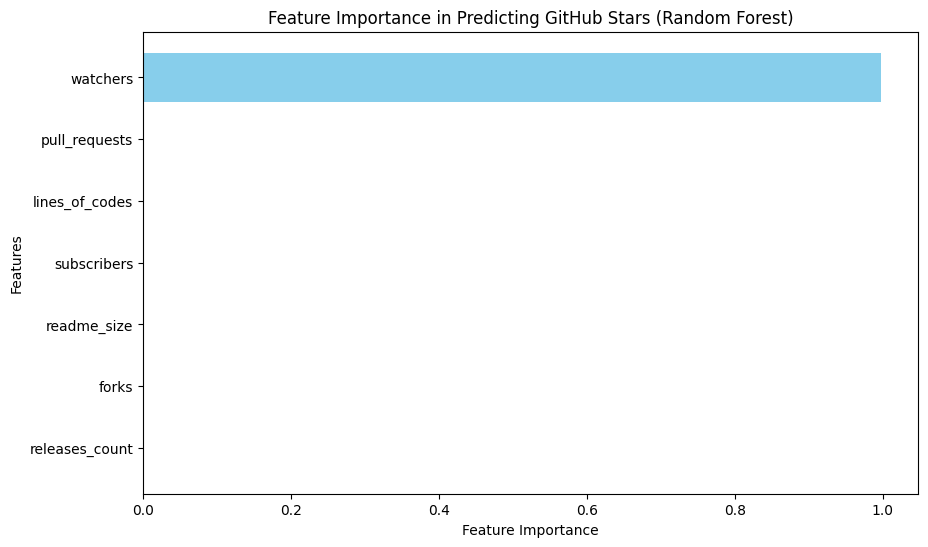

          Feature  Importance
1        watchers    0.997965
4   pull_requests    0.000643
6  lines_of_codes    0.000553
2     subscribers    0.000299
5     readme_size    0.000242
0           forks    0.000194
3  releases_count    0.000104


In [19]:
df['creation_date'] = pd.to_datetime(df['creation_date'])
df['creation_year'] = df['creation_date'].dt.year
df['creation_month'] = df['creation_date'].dt.month

features = ['forks', 'watchers', 'subscribers', 'releases_count', 'pull_requests', 'readme_size', 'lines_of_codes']
X = df[features]
y = df['stars']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2}")

feature_importance = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Predicting GitHub Stars (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df)

# Random Forest，popularity_score_3作为基准

R² score: 0.9793497935681033


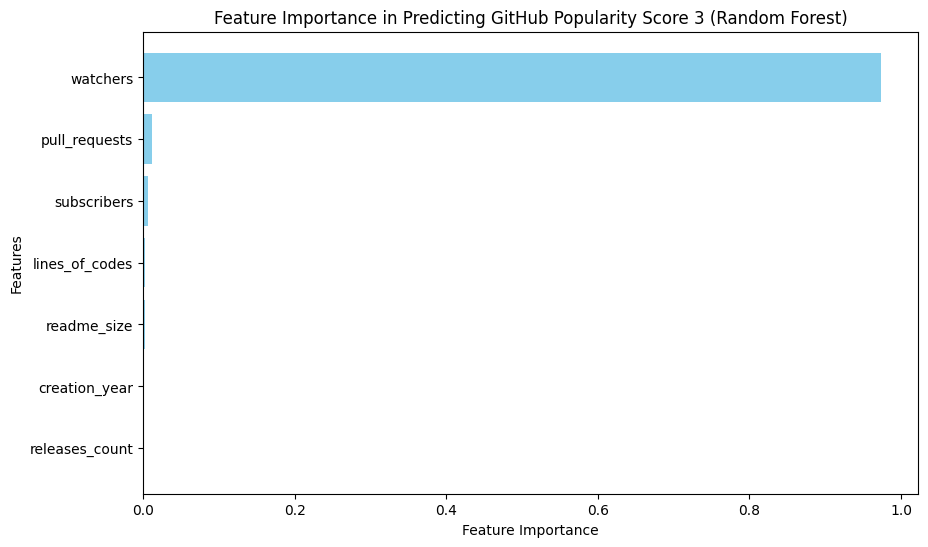

          Feature  Importance
0        watchers    0.973852
4   pull_requests    0.012112
2     subscribers    0.006184
6  lines_of_codes    0.003009
5     readme_size    0.002691
1   creation_year    0.001378
3  releases_count    0.000773


In [9]:
features = ['watchers', 'creation_year', 'subscribers', 'releases_count', 'pull_requests', 'readme_size', 'lines_of_codes']
X = df[features]
y = df['popularity_score_3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2}")

feature_importance = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Predicting GitHub Popularity Score 3 (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df)

# NN，star作为基准

Epoch [1/50], Loss: 16798034.4177
Epoch [2/50], Loss: 4353312.5106
Epoch [3/50], Loss: 2287705.0936
Epoch [4/50], Loss: 951055.3386
Epoch [5/50], Loss: 234504.4164
Epoch [6/50], Loss: 61713.4668
Epoch [7/50], Loss: 34230.6553
Epoch [8/50], Loss: 19890.8113
Epoch [9/50], Loss: 12740.8961
Epoch [10/50], Loss: 7509.0747
Epoch [11/50], Loss: 4470.5290
Epoch [12/50], Loss: 4251.2355
Epoch [13/50], Loss: 2042.5483
Epoch [14/50], Loss: 1368.7256
Epoch [15/50], Loss: 1873.4510
Epoch [16/50], Loss: 889.2175
Epoch [17/50], Loss: 1447.0348
Epoch [18/50], Loss: 662.2969
Epoch [19/50], Loss: 1469.7655
Epoch [20/50], Loss: 626.4993
Epoch [21/50], Loss: 728.7362
Epoch [22/50], Loss: 602.8896
Epoch [23/50], Loss: 1040.0131
Epoch [24/50], Loss: 1368.8173
Epoch [25/50], Loss: 635.3853
Epoch [26/50], Loss: 1771.1377
Epoch [27/50], Loss: 2793.8125
Epoch [28/50], Loss: 249.1593
Epoch [29/50], Loss: 1061.9971
Epoch [30/50], Loss: 937.9053
Epoch [31/50], Loss: 1094.7234
Epoch [32/50], Loss: 796.6855
Epoch [3

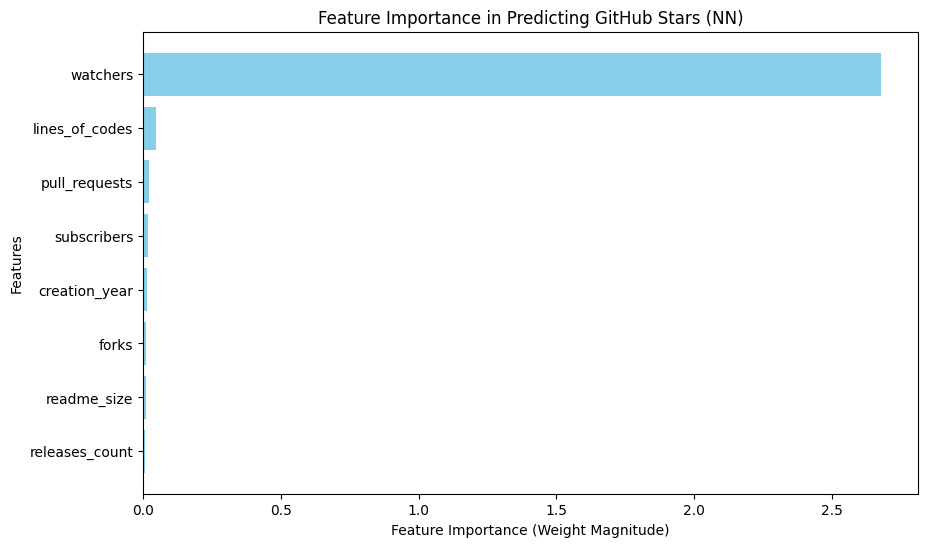

          Feature  Importance
1        watchers    2.678682
7  lines_of_codes    0.046623
5   pull_requests    0.019507
3     subscribers    0.016357
2   creation_year    0.013136
0           forks    0.011133
6     readme_size    0.010814
4  releases_count    0.007647


In [10]:
features = ['forks', 'watchers', 'creation_year', 'subscribers', 'releases_count', 'pull_requests', 'readme_size', 'lines_of_codes']
X = df[features]
y = df['stars']

X = X.fillna(X.mean())
y = y.fillna(y.mean())

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = X.shape[1]
model = GitHubRepoNN(input_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

model.eval()
with torch.no_grad():
    y_test_pred = model(X_test.to(device)).cpu().numpy()

r2 = r2_score(y_test.numpy(), y_test_pred)
print(f"R² score: {r2}")

feature_importance = model.fc1.weight.cpu().detach().numpy()

importance_scores = np.mean(np.abs(feature_importance), axis=0)

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance (Weight Magnitude)")
plt.ylabel("Features")
plt.title("Feature Importance in Predicting GitHub Stars (NN)")
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df)

# NN，popularity_score_3作为基准

Epoch [1/50], Loss: 25355193.0994
Epoch [2/50], Loss: 6302308.7371
Epoch [3/50], Loss: 2822980.7856
Epoch [4/50], Loss: 1657709.2098
Epoch [5/50], Loss: 1219932.3142
Epoch [6/50], Loss: 1101349.1629
Epoch [7/50], Loss: 1039957.9500
Epoch [8/50], Loss: 1010684.9644
Epoch [9/50], Loss: 983623.4825
Epoch [10/50], Loss: 963884.7636
Epoch [11/50], Loss: 946819.0171
Epoch [12/50], Loss: 937018.0135
Epoch [13/50], Loss: 930136.3376
Epoch [14/50], Loss: 924228.9315
Epoch [15/50], Loss: 920279.3116
Epoch [16/50], Loss: 906467.4969
Epoch [17/50], Loss: 900766.6956
Epoch [18/50], Loss: 902125.7683
Epoch [19/50], Loss: 900750.9307
Epoch [20/50], Loss: 895647.9176
Epoch [21/50], Loss: 881428.5344
Epoch [22/50], Loss: 898125.6060
Epoch [23/50], Loss: 887531.4097
Epoch [24/50], Loss: 885473.8812
Epoch [25/50], Loss: 886617.9438
Epoch [26/50], Loss: 885647.9650
Epoch [27/50], Loss: 883188.3395
Epoch [28/50], Loss: 882798.3038
Epoch [29/50], Loss: 876822.5810
Epoch [30/50], Loss: 894274.3281
Epoch [31/

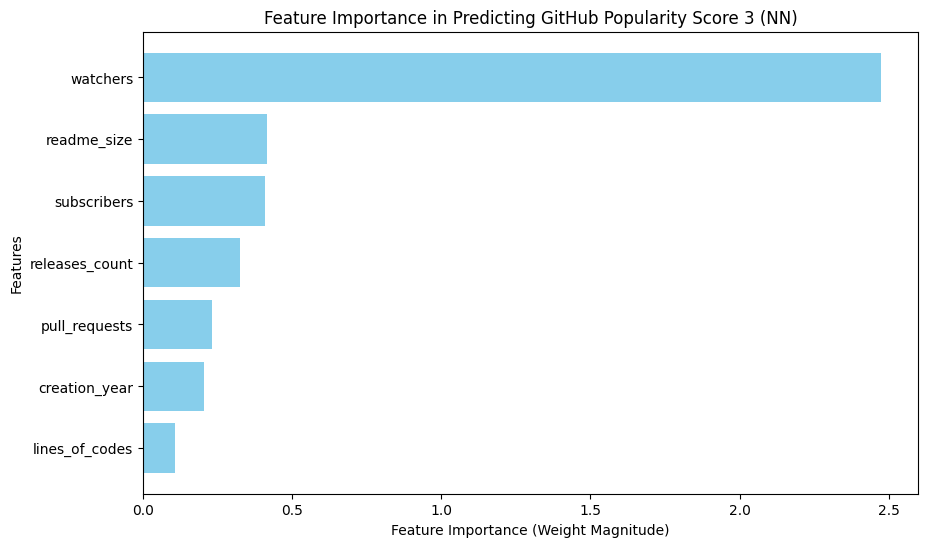

          Feature  Importance
0        watchers    2.475290
5     readme_size    0.415971
2     subscribers    0.409013
3  releases_count    0.325115
4   pull_requests    0.229296
1   creation_year    0.205190
6  lines_of_codes    0.108093


In [11]:
features = ['watchers', 'creation_year', 'subscribers', 'releases_count', 'pull_requests', 'readme_size', 'lines_of_codes']
X = df[features]
y = df['popularity_score_3']

X = X.fillna(X.mean())  # 用均值填充
y = y.fillna(y.mean())

scaler = StandardScaler()
X = scaler.fit_transform(X)  # 归一化特征

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = X.shape[1]
model = GitHubRepoNN(input_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

model.eval()
with torch.no_grad():
    y_test_pred = model(X_test.to(device)).cpu().numpy()

r2 = r2_score(y_test.numpy(), y_test_pred)
print(f"R² score: {r2}")

feature_importance = model.fc1.weight.cpu().detach().numpy()

importance_scores = np.mean(np.abs(feature_importance), axis=0)

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance (Weight Magnitude)")
plt.ylabel("Features")
plt.title("Feature Importance in Predicting GitHub Popularity Score 3 (NN)")
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df)


In [10]:
df

,url,name,owner,forks,stars,languages,commits,creation_date,contributors,topics,...,releases,pull_requests,readme_size,commits_freq,releases_freq,lines_of_codes,popularity_score_1,popularity_score_2,popularity_score_3,releases_count
0,https://api.github.com/repos/0-1-0/lightblue-0.4,lightblue-0.4,0-1-0,91,95,"{'Python': 415988, 'Objective-C': 169036, 'C':...","[2020-10-18T21:26:07Z, 2015-02-11T14:38:50Z, 2...",2012-09-24T02:58:25Z,4,[],...,[],6,3582,8,0,686294,222,131,186,0
1,https://api.github.com/repos/0-8-4/miui-auto-t...,miui-auto-tasks,0-8-4,180,991,"{'Python': 61598, 'Shell': 1087, 'Dockerfile':...","[2025-01-27T05:35:37Z, 2025-01-25T14:24:35Z, 2...",2021-08-16T10:04:15Z,17,"[docker, miui, python, xiaomi]",...,"[{'name': 'v1.8.2-hotfix1', 'date': '2025-01-2...",113,3901,30,51,63304,13940,13760,1171,51
2,https://api.github.com/repos/00-Evan/shattered...,shattered-pixel-dungeon,00-Evan,1158,4936,"{'Java': 6219833, 'Shell': 1977}","[2024-10-09T16:48:17Z, 2024-10-08T18:41:17Z, 2...",2014-07-31T21:56:31Z,2,"[android, game, game-development, ios, java, l...",...,"[{'name': 'v3.0.0-BETA-2.1', 'date': '2024-12-...",46,2467,30,49,6221810,8210,7052,6094,49
3,https://api.github.com/repos/0015/ThatProject,ThatProject,0015,947,1921,"{'C': 41821057, 'C++': 1327597, 'Dart': 510279...","[2024-07-10T06:52:50Z, 2024-06-09T07:27:22Z, 2...",2019-07-04T08:16:56Z,2,"[camera, embedded-project, esp32, esp32-cam, e...",...,[],34,27483,30,0,43896590,4024,3077,2868,0
4,https://api.github.com/repos/007revad/Synology...,Synology_HDD_db,007revad,195,2913,{'Shell': 86699},"[2025-01-23T06:12:05Z, 2025-01-23T06:11:28Z, 2...",2023-02-26T02:59:13Z,11,"[diskstation, dsm, rackstation, synology, syno...",...,"[{'name': 'v3.6.110', 'date': '2024-12-31T10:1...",226,16443,30,88,86699,54184,53989,3108,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185871,https://api.github.com/repos/zzzprojects/Syste...,System.Linq.Dynamic.Core,zzzprojects,230,1597,"{'C#': 1751766, 'HTML': 38859, 'CSS': 26919, '...","[2025-01-19T07:29:42Z, 2024-12-25T08:10:24Z, 2...",2016-04-08T16:41:51Z,30,"[core, dynamic, efcore, entity-framework, enti...",...,"[{'name': 'v.1.5.1', 'date': '2024-12-22T10:28...",318,6902,30,54,1819025,102951,102721,1827,54
185872,https://api.github.com/repos/zzzprojects/Syste...,System.Linq.Dynamic,zzzprojects,194,424,{},"[2024-03-20T20:53:54Z, 2021-04-06T14:35:00Z, 2...",2011-12-12T19:01:13Z,11,"[efcore, entity-framework-core]",...,[],41,2342,30,0,0,2299,2105,618,0
185873,https://api.github.com/repos/zzzprojects/Z.Ext...,Z.ExtensionMethods,zzzprojects,327,1623,"{'C#': 2614721, 'Visual Basic .NET': 1411898}","[2024-03-20T20:50:19Z, 2023-07-05T14:46:07Z, 2...",2015-03-03T14:49:23Z,3,"[csharp, dotnet, dotnet-core, extension-method...",...,"[{'name': 'v2.1.1', 'date': '2019-01-12T18:26:...",15,3996,30,16,4026619,2175,1848,1950,16
185874,https://api.github.com/repos/zzzzbw/Fame,Fame,zzzzbw,72,201,"{'Java': 215298, 'Vue': 121055, 'JavaScript': ...","[2022-12-20T14:34:51Z, 2022-12-14T12:38:56Z, 2...",2017-08-07T13:44:22Z,3,"[docker, docker-compose, fame, java, maven, my...",...,"[{'name': '', 'date': '2022-12-20T10:31:45Z'},...",14,2431,30,3,391989,469,397,273,3
